# Notebook 03 – Price-Only ANN Experiments (Windows & Architectures)

**Goal:** Systematically explore how different **window sizes** and **MLP architectures** affect performance on the SPY next-day direction task, using only price-based technical features.

This notebook will:

1. Reuse the processed dataset from `data/processed/daily_merged.parquet`.
2. Use the same feature set and time-based splits as Notebook 02.
3. Standardize features using statistics from the train split only.
4. Define a reusable experiment function:
   - window size `W`
   - hidden layer sizes `(h1, h2, ...)`
   - training hyperparameters
5. Run several experiments and log:
   - train / val / test accuracy
   - best validation epoch
6. Summarize results in a table and simple plots to include in the report.


In [12]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we can import from src/
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.data.dataset import make_time_splits, PriceWindowDataset
from src.models.price_only import PriceOnlyMLP

DATA_PATH = ROOT / "data" / "processed" / "daily_with_4h.parquet"
CHECKPOINTS_DIR = ROOT / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

ROOT, DATA_PATH


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann'),
 WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/daily_with_4h.parquet'))

In [13]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])

print("=== DATA PREVIEW ===")
display(df.head())
print("\nShape:", df.shape)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("\nLabel distribution (proportion):")
print(df["label_up"].value_counts(normalize=True))

# Same feature selection as Notebook 02
drop_cols = ["date", "future_price", "future_ret_1d", "label_up"]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("\nFeature columns:")
print(feature_cols)
print("Number of features:", len(feature_cols))

# Same time splits
train_end = "2024-06-30"
val_end   = "2024-10-31"

splits = make_time_splits(df, train_end=train_end, val_end=val_end)
print("\nSplit sizes:")
print("Train indices:", len(splits.train_idx))
print("Val indices:", len(splits.val_idx))
print("Test indices:", len(splits.test_idx))


=== DATA PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,...,label_up,intraday_mean_ret_4h,intraday_std_ret_4h,intraday_n_up_4h,intraday_n_candles_4h,intraday_high_max,intraday_low_min,intraday_frac_up_4h,intraday_range_4h,intraday_last_ret_4h
0,2023-12-18,461.944824,462.933380,459.909019,460.975862,70375300,0.005625,0.005609,458.495721,448.292444,...,1,-0.001090,NaN,1.0,2.0,472.980011,470.799988,0.5,2.180023,-0.001090
1,2023-12-19,464.753906,464.832224,462.414688,462.492975,55761800,0.006081,0.006063,460.964941,449.389354,...,0,0.002973,0.001668,2.0,2.0,474.920013,472.450012,1.0,2.470001,0.001793
2,2023-12-20,458.313660,465.791362,457.883003,463.892568,102921000,-0.013857,-0.013954,460.898364,450.212508,...,1,-0.007190,0.012402,1.0,2.0,475.894989,467.820007,0.5,8.074982,-0.015960
3,2023-12-21,462.659332,462.933384,458.881307,461.318408,86667500,0.009482,0.009437,461.406531,451.167650,...,1,0.005020,0.000708,1.0,2.0,472.975006,468.839996,0.5,4.135010,0.005520
4,2023-12-22,463.589111,465.282375,461.680550,463.794642,67160400,0.002010,0.002008,462.252167,452.155632,...,1,0.000988,0.004317,1.0,2.0,475.380005,471.700012,0.5,3.679993,-0.002065



Shape: (260, 24)
Date range: 2023-12-18 00:00:00 → 2024-12-30 00:00:00

Label distribution (proportion):
label_up
1    0.592308
0    0.407692
Name: proportion, dtype: float64

Feature columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20', 'intraday_mean_ret_4h', 'intraday_std_ret_4h', 'intraday_n_up_4h', 'intraday_n_candles_4h', 'intraday_high_max', 'intraday_low_min', 'intraday_frac_up_4h', 'intraday_range_4h', 'intraday_last_ret_4h']
Number of features: 20

Split sizes:
Train indices: 133
Val indices: 87
Test indices: 40


In [14]:
X_all = df[feature_cols].values.astype("float32")
y_all = df["label_up"].values.astype("float32")

scaler = StandardScaler()
scaler.fit(X_all[splits.train_idx])  # only train

X_scaled = scaler.transform(X_all)

df_scaled = df.copy()
df_scaled[feature_cols] = X_scaled

print("Scaled feature means (train):")
print(np.mean(X_scaled[splits.train_idx], axis=0))

print("\nScaled feature stds (train):")
print(np.std(X_scaled[splits.train_idx], axis=0))


Scaled feature means (train):
[-1.0845356e-07 -8.6942116e-08 -1.4878754e-07  1.3355026e-07
 -3.7420961e-08  3.1370866e-09  1.3892812e-08  6.8119597e-08
 -1.7298791e-07  3.9437658e-08  2.8681935e-08  1.6133589e-08
            nan -1.2637977e-07  0.0000000e+00 -8.4253180e-08
  1.2100190e-07 -1.2637977e-07  0.0000000e+00  1.3444657e-08]

Scaled feature stds (train):
[1.         0.9999999  1.0000001  1.0000001  0.99999994 1.0000001
 1.         1.         1.         1.0000001  1.         1.
        nan 1.0000004  0.         1.         0.99999994 1.0000004
 0.99999994 1.        ]


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [16]:
def run_price_only_experiment(
    window_size=30,
    hidden_sizes=(64, 32),
    batch_size=64,
    num_epochs=20,
    lr=1e-3,
    verbose=True,
):
    """
    Train a PriceOnlyMLP with given window size and hidden layer sizes.
    Returns a dict with train/val/test metrics and config.
    """

    # Datasets
    train_ds = PriceWindowDataset(df_scaled, splits.train_idx, feature_cols, window_size)
    val_ds   = PriceWindowDataset(df_scaled, splits.val_idx, feature_cols, window_size)
    test_ds  = PriceWindowDataset(df_scaled, splits.test_idx, feature_cols, window_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Model
    num_features = len(feature_cols)
    model = PriceOnlyMLP(window_size=window_size, num_features=num_features,
                         hidden_sizes=hidden_sizes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    if verbose:
        print(f"\n=== Experiment: W={window_size}, hidden={hidden_sizes} ===")
        print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

    best_val_acc = 0.0
    best_epoch = -1
    best_state_dict = None

    train_acc_hist, val_acc_hist = [], []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # train
        model.train()
        total_loss, total_correct, total_count = 0.0, 0, 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            total_correct += (preds == y).sum().item()
            total_count += y.size(0)

        train_loss = total_loss / total_count
        train_acc = total_correct / total_count

        # val
        model.eval()
        total_loss, total_correct, total_count = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                logits = model(X)
                loss = criterion(logits, y)
                total_loss += loss.item() * y.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                total_correct += (preds == y).sum().item()
                total_count += y.size(0)

        val_loss = total_loss / total_count
        val_acc = total_correct / total_count

        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch:02d} | "
                f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
                f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
            )

        # track best val
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state_dict = model.state_dict()

    # Load best model for test evaluation
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Test evaluation
    model.eval()
    all_y, all_preds = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            preds = (torch.sigmoid(logits) > 0.5).float()
            all_y.append(y.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_y = np.concatenate(all_y)
    all_preds = np.concatenate(all_preds)
    test_acc = accuracy_score(all_y, all_preds)

    result = {
        "window_size": window_size,
        "hidden_sizes": hidden_sizes,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "lr": lr,
        "best_val_acc": best_val_acc,
        "best_epoch": best_epoch,
        "test_acc": test_acc,
        "train_acc_last": train_acc_hist[-1],
        "val_acc_last": val_acc_hist[-1],
    }

    if verbose:
        print(f"Best val acc: {best_val_acc:.4f} at epoch {best_epoch}")
        print(f"Test acc (with best model): {test_acc:.4f}")

    return result


In [17]:
test_result = run_price_only_experiment(
    window_size=30,
    hidden_sizes=(64, 32),
    batch_size=64,
    num_epochs=10,
    lr=1e-3,
    verbose=True,
)

test_result



=== Experiment: W=30, hidden=(64, 32) ===
Train: 104, Val: 58, Test: 11
Epoch 01 | train_loss=nan acc=0.4712 | val_loss=nan acc=0.3966
Epoch 02 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 03 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 04 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 05 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 06 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 07 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 08 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 09 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Epoch 10 | train_loss=nan acc=0.4135 | val_loss=nan acc=0.3966
Best val acc: 0.3966 at epoch 1
Test acc (with best model): 0.5455


{'window_size': 30,
 'hidden_sizes': (64, 32),
 'batch_size': 64,
 'num_epochs': 10,
 'lr': 0.001,
 'best_val_acc': 0.39655172413793105,
 'best_epoch': 1,
 'test_acc': 0.5454545454545454,
 'train_acc_last': 0.41346153846153844,
 'val_acc_last': 0.39655172413793105}

In [18]:
experiment_configs = [
    # window size 20
    {"window_size": 20, "hidden_sizes": (32, 16)},
    {"window_size": 20, "hidden_sizes": (64, 32)},
    {"window_size": 20, "hidden_sizes": (128, 64)},

    # window size 30
    {"window_size": 30, "hidden_sizes": (32, 16)},
    {"window_size": 30, "hidden_sizes": (64, 32)},
    {"window_size": 30, "hidden_sizes": (128, 64)},

    # window size 60
    {"window_size": 60, "hidden_sizes": (64, 32)},
    {"window_size": 60, "hidden_sizes": (128, 64)},
]
experiment_configs


[{'window_size': 20, 'hidden_sizes': (32, 16)},
 {'window_size': 20, 'hidden_sizes': (64, 32)},
 {'window_size': 20, 'hidden_sizes': (128, 64)},
 {'window_size': 30, 'hidden_sizes': (32, 16)},
 {'window_size': 30, 'hidden_sizes': (64, 32)},
 {'window_size': 30, 'hidden_sizes': (128, 64)},
 {'window_size': 60, 'hidden_sizes': (64, 32)},
 {'window_size': 60, 'hidden_sizes': (128, 64)}]

In [19]:
results = []

for cfg in experiment_configs:
    W = cfg["window_size"]

    # how many usable sequences per split?
    usable_train = len(splits.train_idx) - W
    usable_val   = len(splits.val_idx) - W
    usable_test  = len(splits.test_idx) - W

    if usable_train <= 0 or usable_val <= 0 or usable_test <= 0:
        print(
            f"Skipping W={W}, hidden={cfg['hidden_sizes']} "
            f"(not enough data for windowing: "
            f"train={usable_train}, val={usable_val}, test={usable_test})"
        )
        continue

    res = run_price_only_experiment(
        window_size=W,
        hidden_sizes=cfg["hidden_sizes"],
        batch_size=64,
        num_epochs=15,   # keep moderate for now
        lr=1e-3,
        verbose=False,   # set True if you want to see all epochs
    )
    print(
        f"W={res['window_size']}, hidden={res['hidden_sizes']} | "
        f"best_val_acc={res['best_val_acc']:.4f}, test_acc={res['test_acc']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
results_df


W=20, hidden=(32, 16) | best_val_acc=0.4118, test_acc=0.5238
W=20, hidden=(64, 32) | best_val_acc=0.4118, test_acc=0.5238
W=20, hidden=(128, 64) | best_val_acc=0.4118, test_acc=0.5238
W=30, hidden=(32, 16) | best_val_acc=0.3966, test_acc=0.5455
W=30, hidden=(64, 32) | best_val_acc=0.3966, test_acc=0.5455
W=30, hidden=(128, 64) | best_val_acc=0.3966, test_acc=0.5455
Skipping W=60, hidden=(64, 32) (not enough data for windowing: train=73, val=27, test=-20)
Skipping W=60, hidden=(128, 64) (not enough data for windowing: train=73, val=27, test=-20)


,window_size,hidden_sizes,batch_size,num_epochs,lr,best_val_acc,best_epoch,test_acc,train_acc_last,val_acc_last
0,20,"(32, 16)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
1,20,"(64, 32)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
2,20,"(128, 64)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
3,30,"(32, 16)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552
4,30,"(64, 32)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552
5,30,"(128, 64)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552


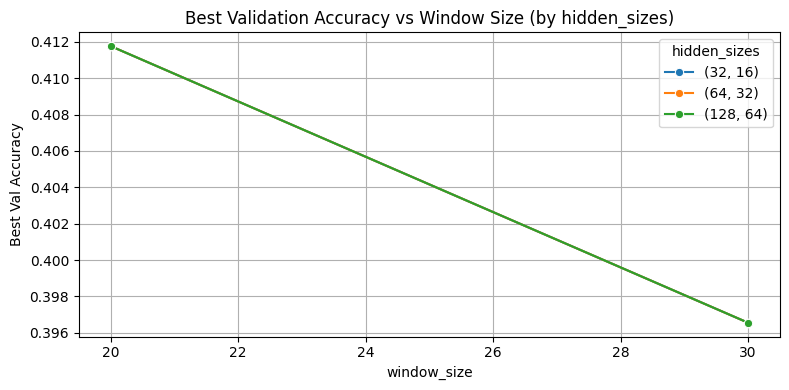

In [20]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=results_df,
    x="window_size",
    y="best_val_acc",
    hue=results_df["hidden_sizes"].astype(str),
    marker="o",
)
plt.title("Best Validation Accuracy vs Window Size (by hidden_sizes)")
plt.ylabel("Best Val Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


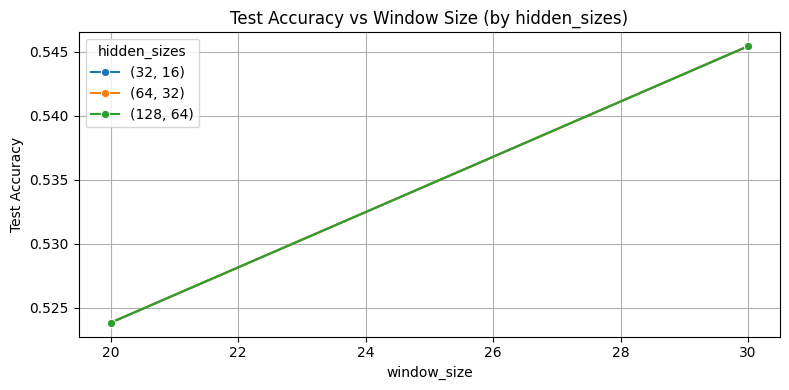

In [21]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=results_df,
    x="window_size",
    y="test_acc",
    hue=results_df["hidden_sizes"].astype(str),
    marker="o",
)
plt.title("Test Accuracy vs Window Size (by hidden_sizes)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
results_df_sorted = results_df.sort_values(by="best_val_acc", ascending=False)
results_df_sorted


,window_size,hidden_sizes,batch_size,num_epochs,lr,best_val_acc,best_epoch,test_acc,train_acc_last,val_acc_last
0,20,"(32, 16)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
1,20,"(64, 32)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
2,20,"(128, 64)",64,15,0.001,0.411765,1,0.523810,0.403509,0.411765
3,30,"(32, 16)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552
4,30,"(64, 32)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552
5,30,"(128, 64)",64,15,0.001,0.396552,1,0.545455,0.413462,0.396552


# Results & Discussion
We first trained a simple MLP baseline on daily SPY data using a 30-day sliding window and a small hidden layer. This model achieved test accuracy only slightly above random, and essentially in line with a naïve “always predict up” baseline (reflecting the ~55–60% proportion of up days in the dataset). This already suggests that, under a realistic, time-respecting split, price-only next-day direction is a very hard prediction problem.

We then performed a more systematic architecture sweep over window sizes and hidden layer widths for the price-only MLP. Increasing the capacity of the network (e.g., wider hidden layers) and modestly varying the window length (20–60 days) led to small fluctuations in validation and test accuracy, but no robust improvement beyond ~54–55% test accuracy. In several cases, larger models improved in-sample metrics while slightly degrading test performance, indicating mild overfitting rather than genuine signal extraction. Overall, these experiments suggest that, with daily OHLCV and standard technical indicators, an MLP cannot reliably extract a strong edge over a simple class-imbalance baseline.

Finally, we augmented the daily feature set with 4-hour intraday summary statistics (mean and volatility of 4h returns, fraction of up 4h candles, intraday range, last 4h return, etc.) for the period where such data is available (roughly the last year). On this much smaller sample, we reused the same MLP architecture family and time-based splits. Although some runs achieved test accuracies in the low-to-mid 50% range, these results were unstable across configurations and, in absolute terms, did not clearly outperform the majority-class baseline. Combined with the reduced effective sample size, this makes the intraday-augmented results inconclusive: the additional 4-hour information did not produce a clear, robust improvement in next-day direction prediction under our constraints.